## Coursera Data Science Capstone Project
This data science project is the capstone project for __Applied Data Science Coursera__

### Introduction
As the largest city in Canada, Toronto combines multi cultures, traditions and foods from all over the world. One of the most popular food you can find in the city is Japanese ramen. While walking on areas like downtown or North York, you will often see find some ramen places that are full of people line up outside, despite winter or summer.


For owners who wish to open a restaurant that offers Japanese ramen, they need to know where the other ramen places located. This is important because it provides owners an overall picture of where their competitors and customers will be mainly located. They also need to know what type of the restaurant should be opened in that area.


This project analyzes all restaurants that serve ramen in Toronto’s boroughs and neighborhoods, and groups similar kind of areas into a cluster, based on ramen places’ rating, price tier and restaurant type, and eventually give owners a guideline of where and how the new ramen places can be located.

### Data Preparation

#### Get Toronto Neighborhood Info from Wikipedia

In [1]:
from bs4 import BeautifulSoup
import requests

In [2]:
r = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')
data = r.text
soup = BeautifulSoup(data)
table = soup.find('table', class_='wikitable sortable')
table_rows = table.tbody.find_all('tr')
l = []
for tr in table_rows:
    td = tr.find_all('td')
    row = [tr.text for tr in td]
    l.append(row)

#### Load Neighbour Info into Data Frame for Preparing and Cleaning

In [3]:
import numpy as np
import pandas as pd

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
toronto_df_raw = pd.DataFrame(l, columns=["Postal Code", "Borough", "Neighborhood"])
toronto_df_raw.shape

(289, 3)

#### Remove Empty Boroughs and Assign Values to Missing Neighborhoods

In [5]:
toronto_df = toronto_df_raw.drop([0])
toronto_df.drop(toronto_df[toronto_df.Borough == "Not assigned"].index, axis=0, inplace=True)
toronto_df.reset_index(drop=True, inplace=True)

for index, row in toronto_df.iterrows():
    row["Neighborhood"] = row["Neighborhood"].replace("\n", "")
    if row["Neighborhood"] == "Not assigned":
        row["Neighborhood"] = row["Borough"]
toronto_df.head(3)

,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront


#### Group Rows by Postal Codes

In [6]:
toronto_df = toronto_df.groupby("Postal Code", as_index=False).agg({'Borough': 'first','Neighborhood': ', '.join})
toronto_df.head()

,Postal Code,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


#### Get Latitude and Longitude for Each Borough

In [7]:
latlng_df = pd.read_csv('https://cocl.us/Geospatial_data')
latlng_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [8]:
toronto_geo_df = pd.merge(toronto_df, latlng_df, on='Postal Code')
toronto_geo_df.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


#### Import Dependency Packages

In [9]:
import json # library to handle JSON files

# !conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

# !conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

#### Get Lat & Long for Toronto

In [10]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


In [11]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(toronto_geo_df['Latitude'], toronto_geo_df['Longitude'], toronto_geo_df['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

#### Config Foursquare API

In [12]:
CLIENT_ID = 'ZWKINQP3WIZJNHNWMOITVYWFSG3XS2QHATT4AALPEUYZZRPT' # your Foursquare ID
CLIENT_SECRET = '10QU5PHSXTORB5ULJCWCQ5LP4K5ELVMSOQ1LTD2DCO54NNDI' # your Foursquare Secret
VERSION = '20190522' # Foursquare API version

#### Note: we can added more attributes like price tier and ratings, however those requires premium api calls and is limited to 500 per day. Hence we will not include here

In [26]:
def addJapaneseRestaurantInfoToData(name, lat, lng, results):
    result_list = []
    for v in results:
        if len(v['categories'])>0:
            venue_detail = venueDetailForRestaurant(v['id'])
            result_list.append((name, 
            lat, 
            lng, 
            v['name'], 
            v['location']['lat'], 
            v['location']['lng'],
            v['categories'][0]['name'],
            venue_detail[0],
            venue_detail[1]))
    return result_list

In [27]:
def venueDetailForRestaurant(venue_id):
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
        venue_id,
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION)
    try:
        results = requests.get(url).json()["response"]["venue"]
        rating = results["rating"] if "rating" in results else 0
        price = results["price"]["tier"] if "price" in results else 0
        return [price, rating]
    except:
        return [0, 0]

In [28]:
def getNearbyJapaneseFood(names, latitudes, longitudes, radius=500):
    
    restaurants_list=[]
    LIMIT=100
    queryJapaneseFood='japanese ramen'
    for name, lat, lng in zip(names, latitudes, longitudes):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&query={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            queryJapaneseFood,
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['venues']
        
        # return only relevant information for each nearby venue
        restaurants_list.append(addJapaneseRestaurantInfoToData(name, lat, lng, results))

    nearby_restaurant = pd.DataFrame([item for restaurant in restaurants_list for item in restaurant])
    nearby_restaurant.columns = ['Neighborhood', 
                            'Neighborhood Latitude', 
                            'Neighborhood Longitude',
                            'Venue', 
                            'Venue Latitude', 
                            'Venue Longitude', 
                            'Venue Category',
                            'Price Tier',
                            'rating']
    return(nearby_restaurant)

In [29]:
toronto_japanese_food = getNearbyJapaneseFood(names=toronto_geo_df['Neighborhood'],
                                   latitudes=toronto_geo_df['Latitude'],
                                   longitudes=toronto_geo_df['Longitude']
                                  )

In [30]:
toronto_japanese_food.shape

(143, 9)

### Let's take a look at those ramen places

In [33]:
toronto_japanese_food.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Price Tier,rating
0,L'Amoreaux West,43.799525,-79.318389,Yamamoto Japanese Cuisine 山本盛世,43.798589,-79.318558,Japanese Restaurant,2,5.5
1,"Fairview, Henry Farm, Oriole",43.778517,-79.346556,Yoi,43.778244,-79.343010,Japanese Restaurant,2,0.0
2,Willowdale South,43.770120,-79.408493,KINTON RAMEN,43.769684,-79.413049,Ramen Restaurant,0,6.7
3,Willowdale South,43.770120,-79.408493,Ajisen Ramen 味千ラーメン,43.771444,-79.413139,Ramen Restaurant,0,6.7
4,Willowdale South,43.770120,-79.408493,Hakata Shoryuken Ramen,43.773519,-79.413872,Ramen Restaurant,0,7.0


In [34]:
toronto_japanese_food.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Price Tier,rating
Neighborhood,,,,,,,,
"Adelaide, King, Richmond",14,14,14,14,14,14,14,14
"Alderwood, Long Branch",1,1,1,1,1,1,1,1
"Bedford Park, Lawrence Manor East",1,1,1,1,1,1,1,1
Berczy Park,1,1,1,1,1,1,1,1
"Brockton, Exhibition Place, Parkdale Village",1,1,1,1,1,1,1,1
"Cabbagetown, St. James Town",1,1,1,1,1,1,1,1
Central Bay Street,13,13,13,13,13,13,13,13
"Chinatown, Grange Park, Kensington Market",4,4,4,4,4,4,4,4
Christie,1,1,1,1,1,1,1,1


### Analyzing Each Neighbourhood

In [36]:
# one hot encoding
toronto_japanese_food_onehot = pd.get_dummies(toronto_japanese_food[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_japanese_food_onehot['Neighborhood'] = toronto_japanese_food['Neighborhood']
toronto_japanese_food_onehot['Price Tier'] = toronto_japanese_food['Price Tier']
toronto_japanese_food_onehot['Rating'] = toronto_japanese_food['rating']

# move neighborhood column to the first column
fixed_columns = [toronto_japanese_food_onehot.columns[-1]] + list(toronto_japanese_food_onehot.columns[:-1])
toronto_japanese_food_onehot = toronto_japanese_food_onehot[fixed_columns]

print(toronto_japanese_food_onehot.shape)
toronto_japanese_food_onehot.head()

(143, 21)


,Rating,Asian Restaurant,Bakery,Café,Church,Dessert Shop,Food Truck,General Entertainment,Gift Shop,Japanese Restaurant,Market,Noodle House,Paper / Office Supplies Store,Pastry Shop,Ramen Restaurant,Restaurant,Sushi Restaurant,Thai Restaurant,Theme Restaurant,Neighborhood,Price Tier
0,5.5,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,L'Amoreaux West,2
1,0.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,"Fairview, Henry Farm, Oriole",2
2,6.7,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,Willowdale South,0
3,6.7,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,Willowdale South,0
4,7.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,Willowdale South,0


#### Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category, as well as the mean of price tier and ratings

In [37]:
toronto_japanese_food_grouped = toronto_japanese_food_onehot.groupby('Neighborhood').mean().reset_index()
toronto_japanese_food_grouped

,Neighborhood,Rating,Asian Restaurant,Bakery,Café,Church,Dessert Shop,Food Truck,General Entertainment,Gift Shop,Japanese Restaurant,Market,Noodle House,Paper / Office Supplies Store,Pastry Shop,Ramen Restaurant,Restaurant,Sushi Restaurant,Thai Restaurant,Theme Restaurant,Price Tier
0,"Adelaide, King, Richmond",4.428571,0.0,0.000000,0.071429,0.0,0.000000,0.000000,0.0,0.0,0.214286,0.0,0.000000,0.0,0.0,0.571429,0.0,0.142857,0.000000,0.000000,1.214286
1,"Alderwood, Long Branch",0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,1.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2,"Bedford Park, Lawrence Manor East",0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,1.000000,0.000000,0.000000,2.000000
3,Berczy Park,8.200000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,1.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,3.000000
4,"Brockton, Exhibition Place, Parkdale Village",6.600000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,1.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,2.000000
5,"Cabbagetown, St. James Town",0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,1.000000,0.0,0.000000,0.000000,0.000000,0.000000
6,Central Bay Street,4.138462,0.0,0.000000,0.076923,0.0,0.076923,0.000000,0.0,0.0,0.153846,0.0,0.153846,0.0,0.0,0.307692,0.0,0.153846,0.000000,0.076923,1.230769
7,"Chinatown, Grange Park, Kensington Market",7.150000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.250000,0.0,0.0,0.500000,0.0,0.250000,0.000000,0.000000,1.750000
8,Christie,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,1.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,2.000000
9,Church and Wellesley,5.230000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.100000,0.0,0.000000,0.0,0.0,0.300000,0.0,0.500000,0.100000,0.000000,1.400000


#### Create Pandas Dataframe for Top 3 Ramen Restaurant Style for Each Neighbourhood

In [42]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [56]:
num_top_venues = 3

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_japanese_food_grouped['Neighborhood']

for ind in np.arange(toronto_japanese_food_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_japanese_food_grouped.iloc[ind, 1:-1], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,"Adelaide, King, Richmond",Ramen Restaurant,Japanese Restaurant,Sushi Restaurant
1,"Alderwood, Long Branch",Market,Theme Restaurant,Gift Shop
2,"Bedford Park, Lawrence Manor East",Sushi Restaurant,Theme Restaurant,Gift Shop
3,Berczy Park,Japanese Restaurant,Thai Restaurant,Bakery
4,"Brockton, Exhibition Place, Parkdale Village",Japanese Restaurant,Thai Restaurant,Bakery


### Cluster Neighbourhoods for Toronto

First we need to find out which K is the best pick for our clustering model, we do so using elbow plot that plots distortion vs K

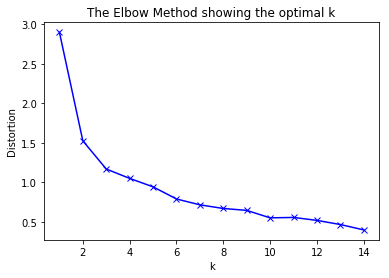

In [57]:
from sklearn import metrics
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

# k means determine k
distortions = []
K = range(1,15)
for k in K: 
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(toronto_japanese_food_grouped_clustering)
    distortions.append(sum(np.min(cdist(toronto_japanese_food_grouped_clustering, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / toronto_japanese_food_grouped_clustering.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Based on the plot, we see that when K is 6 or more, distortion decreasing pace is slowed down, so let's choose K = 6

In [58]:
# set number of clusters
kclusters = 6

toronto_japanese_food_grouped_clustering = toronto_japanese_food_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_japanese_food_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 1, 3, 2, 2, 1, 0, 2, 3, 5, 5, 3, 3, 1, 5, 2, 3, 0, 4, 1, 0, 5,
       1, 2, 4, 5, 0, 5, 2, 4, 0, 3, 5], dtype=int32)

In [59]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

neighborhoods_venues_sorted = neighborhoods_venues_sorted.reset_index()
toronto_japanese_food_merged = toronto_geo_df

toronto_japanese_food_merged = pd.merge(toronto_japanese_food_merged, neighborhoods_venues_sorted, on='Neighborhood')

toronto_japanese_food_merged.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude,index,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,M1W,Scarborough,L'Amoreaux West,43.799525,-79.318389,21,5,Japanese Restaurant,Thai Restaurant,Bakery
1,M2J,North York,"Fairview, Henry Farm, Oriole",43.778517,-79.346556,16,3,Japanese Restaurant,Thai Restaurant,Bakery
2,M2N,North York,Willowdale South,43.770120,-79.408493,32,5,Ramen Restaurant,Japanese Restaurant,Gift Shop
3,M3B,North York,Don Mills North,43.745906,-79.352188,15,2,Japanese Restaurant,Thai Restaurant,Bakery
4,M3C,North York,"Flemingdon Park, Don Mills South",43.725900,-79.340923,18,4,General Entertainment,Theme Restaurant,Thai Restaurant


### Visualize the Clustering of Ramen Restaurant in Toronto

In [60]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, top_common, sec_common, third_common in zip(toronto_japanese_food_merged['Latitude'], 
                                                          toronto_japanese_food_merged['Longitude'], 
                                                          toronto_japanese_food_merged['Neighborhood'], 
                                                          toronto_japanese_food_merged['Cluster Labels'], 
                                                          toronto_japanese_food_merged['1st Most Common Venue'], 
                                                          toronto_japanese_food_merged['2nd Most Common Venue'],
                                                          toronto_japanese_food_merged['3rd Most Common Venue']):
#     label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    label = folium.Popup(str(poi) + ' \n' + '1st Common: ' + top_common + ' \n' + '2nd Common: ' + sec_common + ' \n' + '3rd Common: ' + third_common, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

In [61]:
display(map_clusters)